---
# Object Detection/Localizator
---
## Tasks Outline:

#### Idea: start with the most basic task, gradually make it more complex 
* Step 1) identify actual boxes
* Step 2) locate an actual object (a Pokemon)
* Step 3) different sized objects
* Step 4) flipped objects
* Step 5) add actual backgrounds 
* Step 6) object may not appear 
* Step 7) multiple classes of objects

---
---
# Step 1) identify actual boxes
---
---

In [18]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


2.10.0


In [19]:
vgg = tf.keras.applications.VGG16(input_shape=[100, 100, 3],
                                  include_top=False,
                                  weights='imagenet')

In [20]:
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model = Model(vgg.input, x)

In [4]:
def image_generator(batch_size=64):
    # generate image and targets
    while True:
        for _ in range(50): # Each epoch will have 50 batches. (No important reason)
            X = np.zeros((batch_size, 100, 100, 3)) #100x100 images with rgb
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size): #make boxes and store their location in the target
                row0 = np.random.randint(90)
                col0 = np.random.randint(90)
                row1 = np.random.randint(row0, 90) #row0<row1 #no negative dimensions
                col1 = np.random.randint(col0, 90) #col0<col1
                #Create input (X):
                X[i,row0:row1,col0:col1,:]=1 #i'th element in the batch, between row&cols and every RGB = 1
                #Create output/Targets (Y):
                Y[i,0] = row0/100.        #top left corner(x1) + normalization
                Y[i,1] = col0/100.        #top left corner(y1) + normalization
                Y[i,2] = (row1-row0)/100. #bottom right corner(x2) + normalization
                Y[i,3] = (col1-col0)/100. #bottom right corner(y2) + normalization
        yield X, Y # instead of return we use yield

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001))

c:\Users\Giray\Coding_Courses\Ai\tensorflow_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
model.fit(
    x=image_generator(batch_size=64),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5
50/50 [==============================] - 13s 246ms/step - loss: 0.6797
Epoch 2/5
50/50 [==============================] - 12s 239ms/step - loss: 0.5311
Epoch 3/5
50/50 [==============================] - 12s 240ms/step - loss: 0.4952
Epoch 4/5
50/50 [==============================] - 12s 241ms/step - loss: 0.4926
Epoch 5/5
50/50 [==============================] - 12s 237ms/step - loss: 0.4951


In [7]:
from matplotlib.patches import Rectangle

# Make predictions

def make_prediction():
    #generate random img
    x = np.zeros((100,100,3)) #create background
    #create box
    row0 = np.random.randint(90)
    col0 = np.random.randint(90)
    row1 = np.random.randint(row0,100)
    col1 = np.random.randint(col0,100)
    x[row0:row1,col0:col1,:] = 1
    print((row0, col0, row1, col1))

    #Predict
    X= np.expand_dims(x, 0) # batch_size = 0
    p = model.predict(X)[0] # prediction has batch_size of 1, we can select first idx

    #Draw the box
    fig, ax = plt.subplots(1)
    ax.imshow(x)
    rect = Rectangle((p[1]*100, p[0]*100), #matplotlib wants unnormalized coordinates, and also in a different order.
                      p[3]*100,
                      p[2]*100,
                      linewidth=1,
                      edgecolor="r",
                      facecolor='None')
    ax.add_patch(rect)
    plt.show()

(12, 19, 85, 48)
1/1 [==============================] - 0s 19ms/step


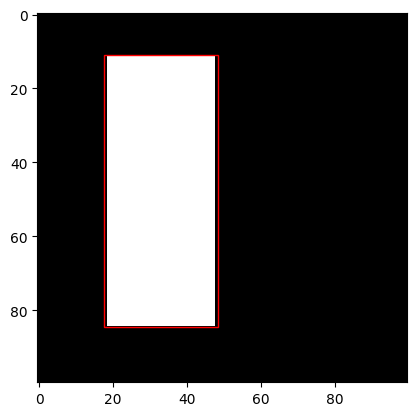

(65, 74, 76, 88)
1/1 [==============================] - 0s 19ms/step


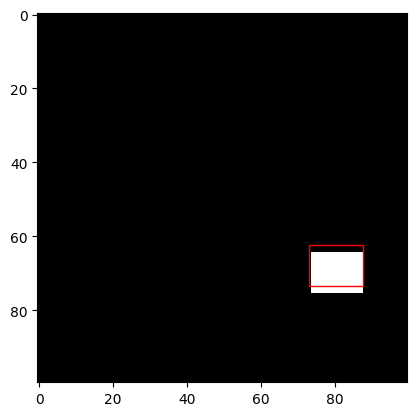

(18, 37, 54, 41)
1/1 [==============================] - 0s 19ms/step


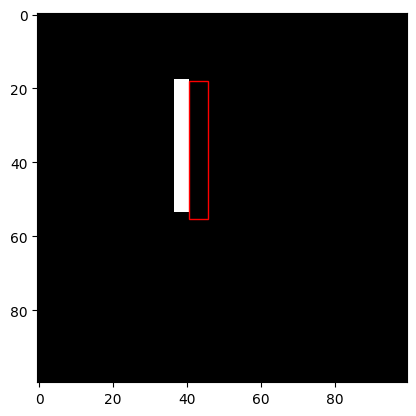

(84, 40, 88, 96)
1/1 [==============================] - 0s 18ms/step


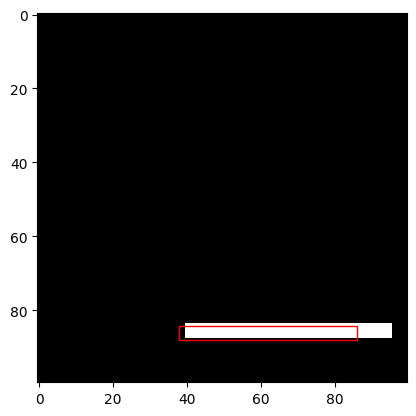

(61, 20, 79, 36)
1/1 [==============================] - 0s 19ms/step


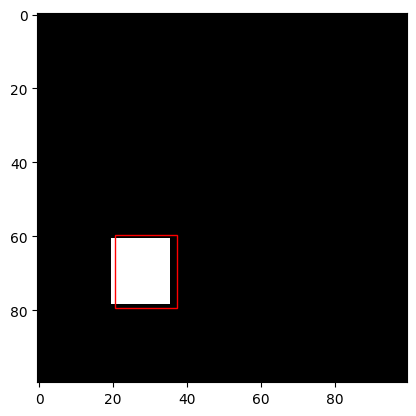

In [10]:
for i in range(5):
    make_prediction()

---
---
# Step 2) locate an actual object (a Pokemon)
---
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load image method 1:
from tensorflow.keras.preprocessing import image

(56, 44, 3)
<class 'PIL.Image.Image'>


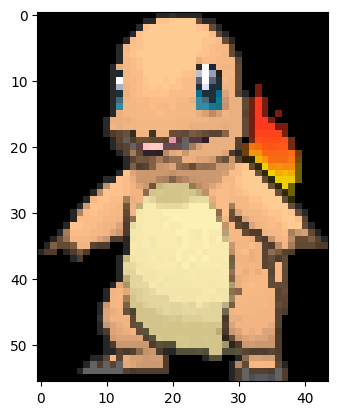

In [3]:
# object is in the tightest box possible
ch = image.load_img('charmander-tight.png')
plt.imshow(ch)

print(np.array(ch).shape)
print(type(ch))
# background is black, RGB

In [4]:
# load image method 2:
import imageio.v2 as imageio

(56, 44, 4)
<class 'numpy.ndarray'>


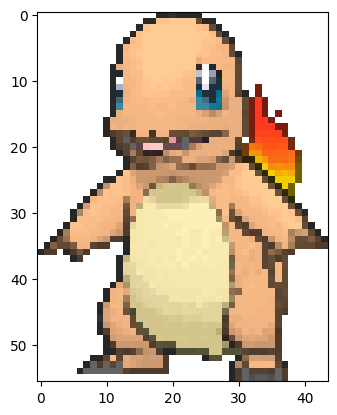

In [5]:
ch = imageio.imread('charmander-tight.png')
plt.imshow(ch)

print(np.array(ch).shape)
print(type(ch))
# background is white, RGBA

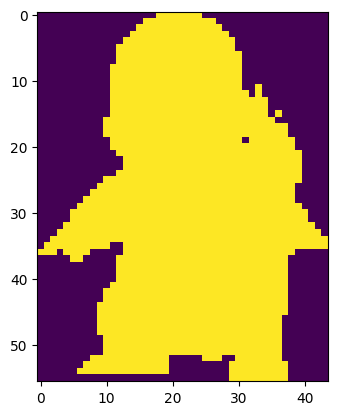

In [6]:
#plot alpha channel, (4th channel)
plt.imshow(ch[:,:,3])
plt.show()

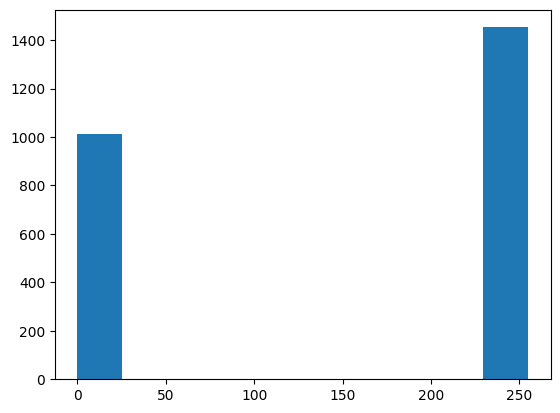

{0, 255}

In [7]:
plt.hist(ch[:,:,3].flatten()) # check possible pixel values by histogram
plt.show()

set(ch[:,:,3].flatten()) # see 1 possible value per element with set

In [8]:
# image generator
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape
print(CH_H, CH_W, _)

def pokemon_generator(batch_size=64):
    # generate image and targets
    while True:
        for _ in range(50): # Each epoch will have 50 batches. (No important reason)
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3)) #POKE_DIMxPOKE_DIM images with rgb
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size): #make boxes and store their location in the target
                row0 = np.random.randint(POKE_DIM - CH_H) # CH has fixed size.
                col0 = np.random.randint(POKE_DIM - CH_W)
                row1 = row0 + CH_H
                col1 = col0 + CH_W
                #Create input (X):
                X[i,row0:row1,col0:col1,:]= ch[:,:,:3] #i'th element in the batch
                #Create output/Targets (Y):
                Y[i,0] = row0/POKE_DIM        #top left corner(x1) + normalization
                Y[i,1] = col0/POKE_DIM        #top left corner(y1) + normalization
                Y[i,2] = (row1-row0)/POKE_DIM #bottom right corner(x2) + normalization
                Y[i,3] = (col1-col0)/POKE_DIM #bottom right corner(y2) + normalization
            yield X / 255., Y # instead of return we use yield    

56 44 4


In [9]:
def make_model():
    vgg = tf.keras.applications.VGG16(input_shape=[POKE_DIM, POKE_DIM, 3],
                                      include_top=False,
                                      weights='imagenet')
    x = Flatten()(vgg.output)
    x = Dense(4, activation='sigmoid')(x)
    model = Model(vgg.input, x)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001))
    return model

In [36]:
model = make_model()
model.fit(x=pokemon_generator(batch_size=64),
          steps_per_epoch=50,
          epochs=5)

Epoch 1/5
50/50 [==============================] - 37s 717ms/step - loss: 0.6853
Epoch 2/5
50/50 [==============================] - 36s 715ms/step - loss: 0.5561
Epoch 3/5
50/50 [==============================] - 36s 717ms/step - loss: 0.5536
Epoch 4/5
50/50 [==============================] - 36s 719ms/step - loss: 0.5547
Epoch 5/5
50/50 [==============================] - 37s 735ms/step - loss: 0.5535


In [10]:
from matplotlib.patches import Rectangle

# Make predictions

def pokemon_prediction():
    #generate random img
    x = np.zeros((POKE_DIM,POKE_DIM,3)) #create background
    #create box
    row0 = np.random.randint(POKE_DIM - CH_H) # CH has fixed size.
    col0 = np.random.randint(POKE_DIM - CH_W)
    row1 = row0 + CH_H
    col1 = col0 + CH_W
    x[row0:row1,col0:col1,:]= ch[:,:,:3] #i'th element in the batch
    print("True:",row0, col0, row1, col1)

    #Predict
    X= np.expand_dims(x, 0)/255. # batch_size = 0
    p = model.predict(X)[0] # prediction has batch_size of 1, we can select first idx
    
    #Calculate Target / Loss
    y = np.zeros(4)
    y[0] = row0/POKE_DIM        #top left corner(x1) + normalization
    y[1] = col0/POKE_DIM        #top left corner(y1) + normalization
    y[2] = (row1-row0)/POKE_DIM #bottom right corner(x2) + normalization
    y[3] = (col1-col0)/POKE_DIM #bottom right corner(y2) + normalization

    #Draw the box
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0+p[2]*POKE_DIM)
    col1 = int(col0+p[3]*POKE_DIM)
    print("Pred:",row0, col0, row1, col1)
    print("Loss:",-np.mean(y*np.log(p)+(1-y)*np.log(1-p)))

    #Draw the box
    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect = Rectangle((p[1]*POKE_DIM, p[0]*POKE_DIM), #matplotlib wants unnormalized coordinates, and also in a different order.
                      p[3]*POKE_DIM,
                      p[2]*POKE_DIM,
                      linewidth=1,
                      edgecolor="r",
                      facecolor='None')
    ax.add_patch(rect)
    plt.show()    

True: 121 20 177 64
1/1 [==============================] - 0s 221ms/step
Pred: 120 20 175 64
Loss: 0.5290179888531565


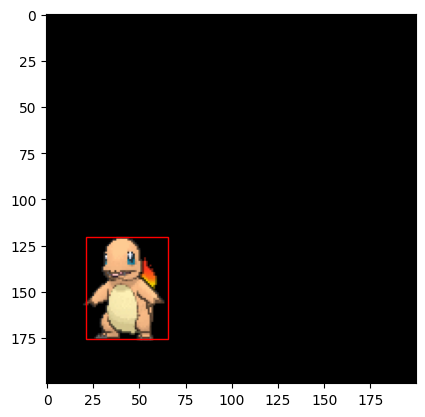

True: 77 59 133 103
1/1 [==============================] - 0s 28ms/step
Pred: 77 59 133 103
Loss: 0.59822928737849


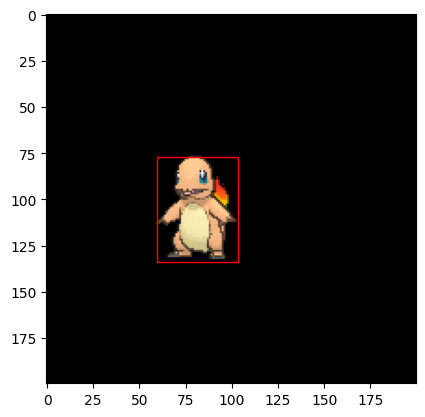

True: 120 138 176 182
1/1 [==============================] - 0s 25ms/step
Pred: 121 137 177 180
Loss: 0.6030467640608549


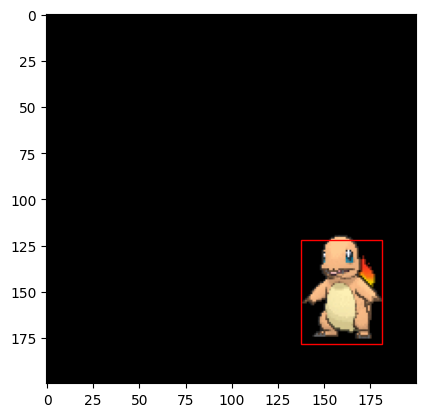

True: 13 94 69 138
1/1 [==============================] - 0s 24ms/step
Pred: 13 95 68 138
Loss: 0.5129872770793735


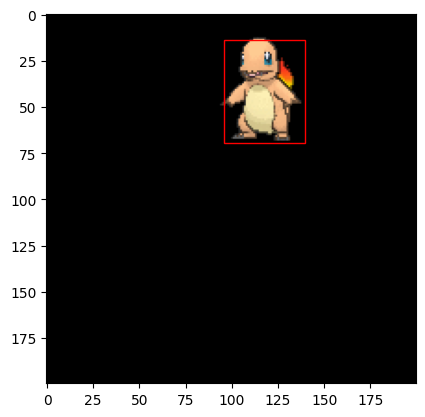

True: 82 6 138 50
1/1 [==============================] - 0s 23ms/step
Pred: 83 5 138 49
Loss: 0.48289796149823816


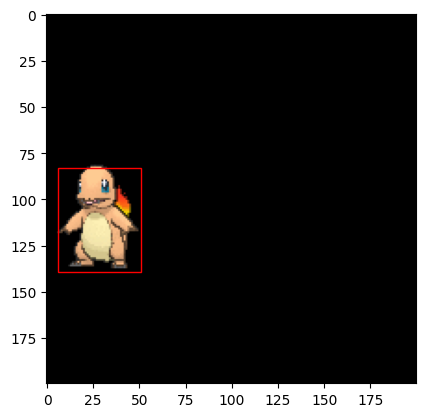

In [38]:
for i in range(5):
    pokemon_prediction()

---
---
# Step 3) different sized objects
---
---

In [11]:
# image generator
from skimage.transform import resize

def pokemon_generator_with_resize(batch_size=64):
    # generate image and targets
    while True:
        for _ in range(50): # Each epoch will have 50 batches. (No important reason)
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3)) #POKE_DIMxPOKE_DIM images with rgb
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size): #make boxes and store their location in the target
                #resizer
                scale = 0.1 + np.random.random()*3 #[0.1, 4.1]
                new_height = int(CH_H*scale)
                new_width  = int(CH_W*scale)

                obj = resize(ch,
                             (new_height,new_width),
                             preserve_range=True).astype(np.uint8) # keep it from 0..255

                row0 = np.random.randint(POKE_DIM - new_height)
                col0 = np.random.randint(POKE_DIM - new_width)
                row1 = row0 + new_height
                col1 = col0 + new_width
                #Create input (X):
                X[i,row0:row1,col0:col1,:]= obj[:,:,:3] #i'th element in the batch
                #Create output/Targets (Y):
                Y[i,0] = row0/POKE_DIM        #top left corner(x1) + normalization
                Y[i,1] = col0/POKE_DIM        #top left corner(y1) + normalization
                Y[i,2] = (row1-row0)/POKE_DIM #bottom right corner(x2) + normalization
                Y[i,3] = (col1-col0)/POKE_DIM #bottom right corner(y2) + normalization
            yield X / 255., Y # instead of return we use yield    

In [12]:
def make_model2():
    vgg = tf.keras.applications.VGG16(input_shape=[POKE_DIM, POKE_DIM, 3],
                                      include_top=False,
                                      weights='imagenet')
    x = Flatten()(vgg.output)
    x = Dense(4, activation='sigmoid')(x)
    model = Model(vgg.input, x)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001))
    return model

In [77]:
model = make_model2()
model.fit(x=pokemon_generator_with_resize(batch_size=64),
          steps_per_epoch=50,
          epochs=5)

Epoch 1/5
50/50 [==============================] - 38s 738ms/step - loss: 0.5491
Epoch 2/5
50/50 [==============================] - 37s 740ms/step - loss: 0.5257
Epoch 3/5
50/50 [==============================] - 37s 749ms/step - loss: 0.5228
Epoch 4/5
50/50 [==============================] - 39s 780ms/step - loss: 0.5211
Epoch 5/5
50/50 [==============================] - 40s 802ms/step - loss: 0.5229


In [13]:
from matplotlib.patches import Rectangle

# Make predictions

def pokemon_prediction_with_resize():
    #resizer
    scale = 0.5 + np.random.random() #[0.5, 1.5]
    new_height = int(CH_H*scale)
    new_width  = int(CH_W*scale)
    obj = resize(ch,
                 (new_height,new_width),
                 preserve_range=True).astype(np.uint8) # keep it from 0..255

    x = np.zeros((POKE_DIM,POKE_DIM,3)) #create background
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

    x[row0:row1,col0:col1,:]= obj[:,:,:3]
    print("True:",row0, col0, row1, col1)

    #Predict
    X= np.expand_dims(x, 0)/255. # batch_size = 0
    p = model.predict(X)[0] # prediction has batch_size of 1, we can select first idx
    
    #Calculate Target / Loss
    y = np.zeros(4)
    y[0] = row0/POKE_DIM        #top left corner(x1) + normalization
    y[1] = col0/POKE_DIM        #top left corner(y1) + normalization
    y[2] = (row1-row0)/POKE_DIM #bottom right corner(x2) + normalization
    y[3] = (col1-col0)/POKE_DIM #bottom right corner(y2) + normalization

    #Draw the box
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0+p[2]*POKE_DIM)
    col1 = int(col0+p[3]*POKE_DIM)
    print("Pred:",row0, col0, row1, col1)
    print("Loss:",-np.mean(y*np.log(p)+(1-y)*np.log(1-p)))

    #Draw the box
    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect = Rectangle((p[1]*POKE_DIM, p[0]*POKE_DIM), #matplotlib wants unnormalized coordinates, and also in a different order.
                      p[3]*POKE_DIM,
                      p[2]*POKE_DIM,
                      linewidth=1,
                      edgecolor="r",
                      facecolor='None')
    ax.add_patch(rect)
    plt.show()    

True: 42 127 116 185
1/1 [==============================] - 0s 22ms/step
Pred: 40 126 113 183
Loss: 0.6079080185294151


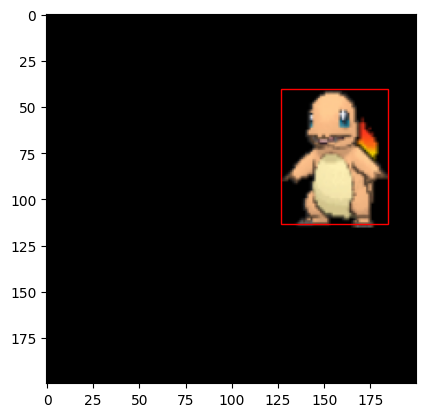

True: 49 13 129 76
1/1 [==============================] - 0s 18ms/step
Pred: 48 13 127 75
Loss: 0.52337123288773


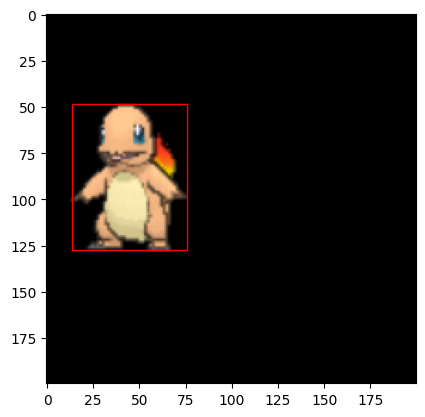

True: 117 41 181 91
1/1 [==============================] - 0s 24ms/step
Pred: 116 40 179 89
Loss: 0.5937887481600046


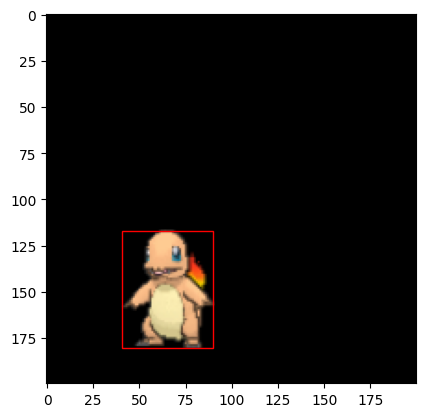

True: 92 133 136 167
1/1 [==============================] - 0s 20ms/step
Pred: 91 131 137 164
Loss: 0.5777065542340278


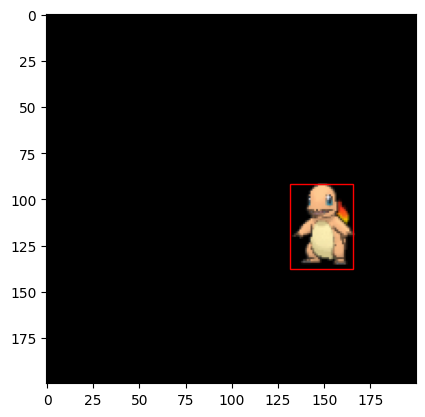

True: 21 124 79 170
1/1 [==============================] - 0s 20ms/step
Pred: 20 125 78 168
Loss: 0.535559517564252


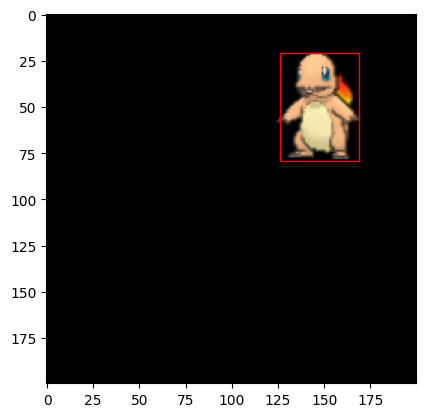

In [80]:
for i in range(5):
    pokemon_prediction_with_resize()

---
---
# Step 4) flipped objects
---
---

In [16]:
# image generator
from skimage.transform import resize
import tensorflow as tf

def pokemon_generator_flip(batch_size=64):
    # generate image and targets
    while True:
        for _ in range(50): # Each epoch will have 50 batches. (No important reason)
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3)) #POKE_DIMxPOKE_DIM images with rgb
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size): #make boxes and store their location in the target
                row0 = np.random.randint(POKE_DIM - CH_H)
                col0 = np.random.randint(POKE_DIM - CH_W)
                row1 = row0 + CH_H
                col1 = col0 + CH_W                
                
                # flip
                if np.random.random()<0.5:
                    obj = np.fliplr(ch)
                else:
                    obj = ch
                
                #Create input (X):
                X[i,row0:row1,col0:col1,:]= obj[:,:,:3] #i'th element in the batch
                #Create output/Targets (Y):
                Y[i,0] = row0/POKE_DIM        #top left corner(x1) + normalization
                Y[i,1] = col0/POKE_DIM        #top left corner(y1) + normalization
                Y[i,2] = (row1-row0)/POKE_DIM #bottom right corner(x2) + normalization
                Y[i,3] = (col1-col0)/POKE_DIM #bottom right corner(y2) + normalization
            yield X / 255., Y # instead of return we use yield    

In [21]:
model = make_model()
model.fit(x=pokemon_generator_flip(batch_size=64),
          steps_per_epoch=50,
          epochs=5)

Epoch 1/5
50/50 [==============================] - 37s 722ms/step - loss: 0.6907
Epoch 2/5
50/50 [==============================] - 36s 722ms/step - loss: 0.5546
Epoch 3/5
50/50 [==============================] - 36s 723ms/step - loss: 0.5559
Epoch 4/5
50/50 [==============================] - 36s 725ms/step - loss: 0.5557
Epoch 5/5
50/50 [==============================] - 36s 726ms/step - loss: 0.5537


In [22]:
from matplotlib.patches import Rectangle

# Make predictions

def pokemon_prediction_with_resize():
    x = np.zeros((POKE_DIM,POKE_DIM,3)) #create background
    row0 = np.random.randint(POKE_DIM - CH_H)
    col0 = np.random.randint(POKE_DIM - CH_W)
    row1 = row0 + CH_H
    col1 = col0 + CH_W

    # flip
    if np.random.random() < 0.5:
        obj = np.fliplr(ch)
    else:
        obj = ch

    x[row0:row1,col0:col1,:]= obj[:,:,:3]
    print("True:",row0, col0, row1, col1)

    #Predict
    X= np.expand_dims(x, 0)/255. # batch_size = 0
    p = model.predict(X)[0] # prediction has batch_size of 1, we can select first idx
    
    #Calculate Target / Loss
    y = np.zeros(4)
    y[0] = row0/POKE_DIM        #top left corner(x1) + normalization
    y[1] = col0/POKE_DIM        #top left corner(y1) + normalization
    y[2] = (row1-row0)/POKE_DIM #bottom right corner(x2) + normalization
    y[3] = (col1-col0)/POKE_DIM #bottom right corner(y2) + normalization

    #Draw the box
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0+p[2]*POKE_DIM)
    col1 = int(col0+p[3]*POKE_DIM)
    print("Pred:",row0, col0, row1, col1)
    print("Loss:",-np.mean(y*np.log(p)+(1-y)*np.log(1-p)))

    #Draw the box
    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect = Rectangle((p[1]*POKE_DIM, p[0]*POKE_DIM), #matplotlib wants unnormalized coordinates, and also in a different order.
                      p[3]*POKE_DIM,
                      p[2]*POKE_DIM,
                      linewidth=1,
                      edgecolor="r",
                      facecolor='None')
    ax.add_patch(rect)
    plt.show()    

True: 72 135 128 179
1/1 [==============================] - 0s 17ms/step
Pred: 72 134 125 178
Loss: 0.6010552248731256


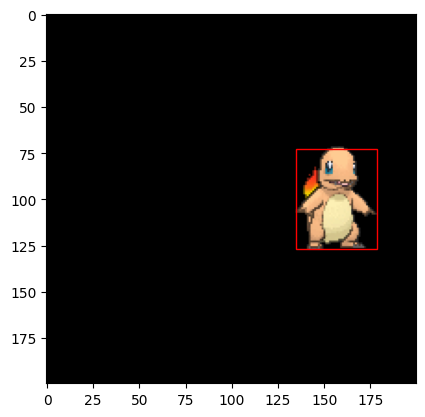

True: 100 72 156 116
1/1 [==============================] - 0s 18ms/step
Pred: 101 73 156 116
Loss: 0.6166691187024117


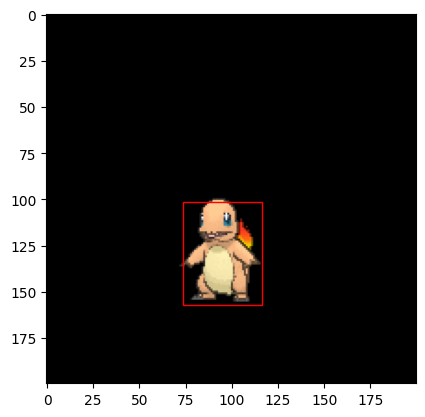

True: 76 29 132 73
1/1 [==============================] - 0s 19ms/step
Pred: 76 29 131 72
Loss: 0.5494718793034553


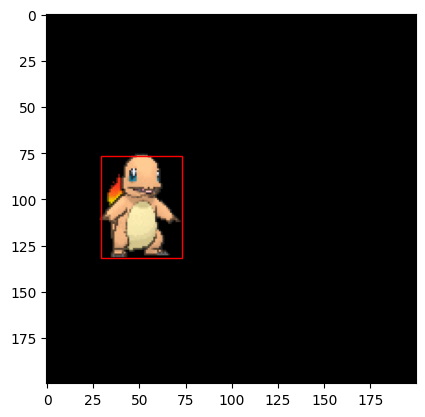

True: 22 32 78 76
1/1 [==============================] - 0s 19ms/step
Pred: 22 34 77 77
Loss: 0.47665622329339385


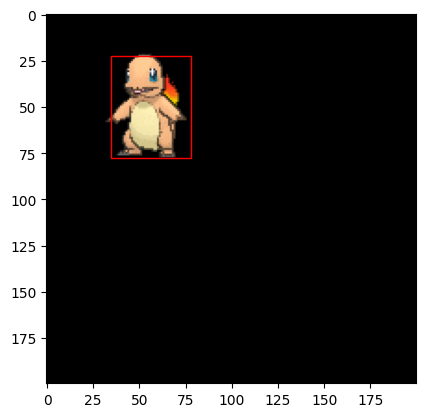

True: 66 105 122 149
1/1 [==============================] - 0s 18ms/step
Pred: 67 106 124 149
Loss: 0.6115685305744409


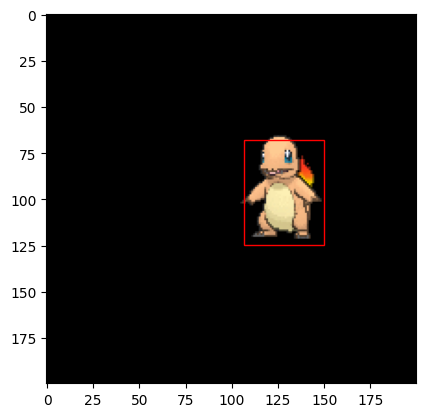

In [28]:
for i in range(5):
    pokemon_prediction_with_resize()